In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (11, 7)


In [2]:
def boxplot(*args, **kwargs):
    labels = kwargs.pop('label', None)
    return sns.boxplot(*args, **kwargs)

In [2]:
payment_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 
                    'deferral_payments', 'loan_advances', 'other', 'expenses', 
                   'director_fees', 'total_payments']

stock_features = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']

email_features =  ['to_messages', 'email_address', 'from_poi_to_this_person', 
                   'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

label = 'poi'

feature_names = payment_features + stock_features + email_features
feature_names.remove('email_address')

In [3]:
def load_data():
    d = pd.read_csv('enron_employees.csv', na_values='NaN')

    # Outliers
    d = d[d.full_name != 'LAY KENNETH L']
    return d

data = load_data()


In [4]:
poi_count = len(data[data.poi == True])
non_poi_count = len(data[data.poi == False])

print("Number of POIs:\t\t%d" % poi_count)
print("Number of non-POIs:\t%d" % non_poi_count)
print("Total number:\t\t%d" % (poi_count + non_poi_count))
print("Datset balance:\t\t%0.3f" % data.poi.mean())
print("\nNumber of features:\t%d" % len(feature_names))


Number of POIs:		17
Number of non-POIs:	127
Total number:		144
Datset balance:		0.118

Number of features:	19


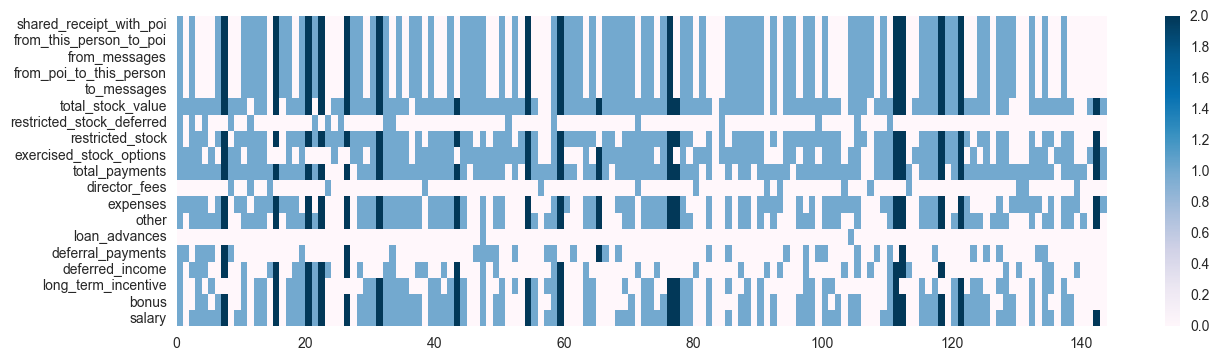

In [734]:
def plot_data_presence_map(data):
    data_presence = np.logical_not(np.isnan(data.as_matrix(feature_names))).T.astype(float)
    poi_marker = data.poi.as_matrix().astype(float) + 1
    data_presence = data_presence * poi_marker
    
    plt.figure(figsize=(15, 4))
    g = plt.pcolormesh(data_presence, cmap='PuBu')
    plt.xlim(0, data_presence.shape[1])
    plt.ylim(0, data_presence.shape[0])
    plt.colorbar()

    g.axes.set_yticks(np.arange(len(feature_names)) + 0.5)
    g.axes.set_yticklabels(feature_names);

plot_data_presence_map(data)

In [640]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler

preproc_pipeline = Pipeline([
        ('imputer', Imputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

preproc_data = preproc_pipeline.fit_transform(data[feature_names])
preproc_data = pd.DataFrame(preproc_data, columns=feature_names, index=data.index)
preproc_data[label] = data[label].astype(int)

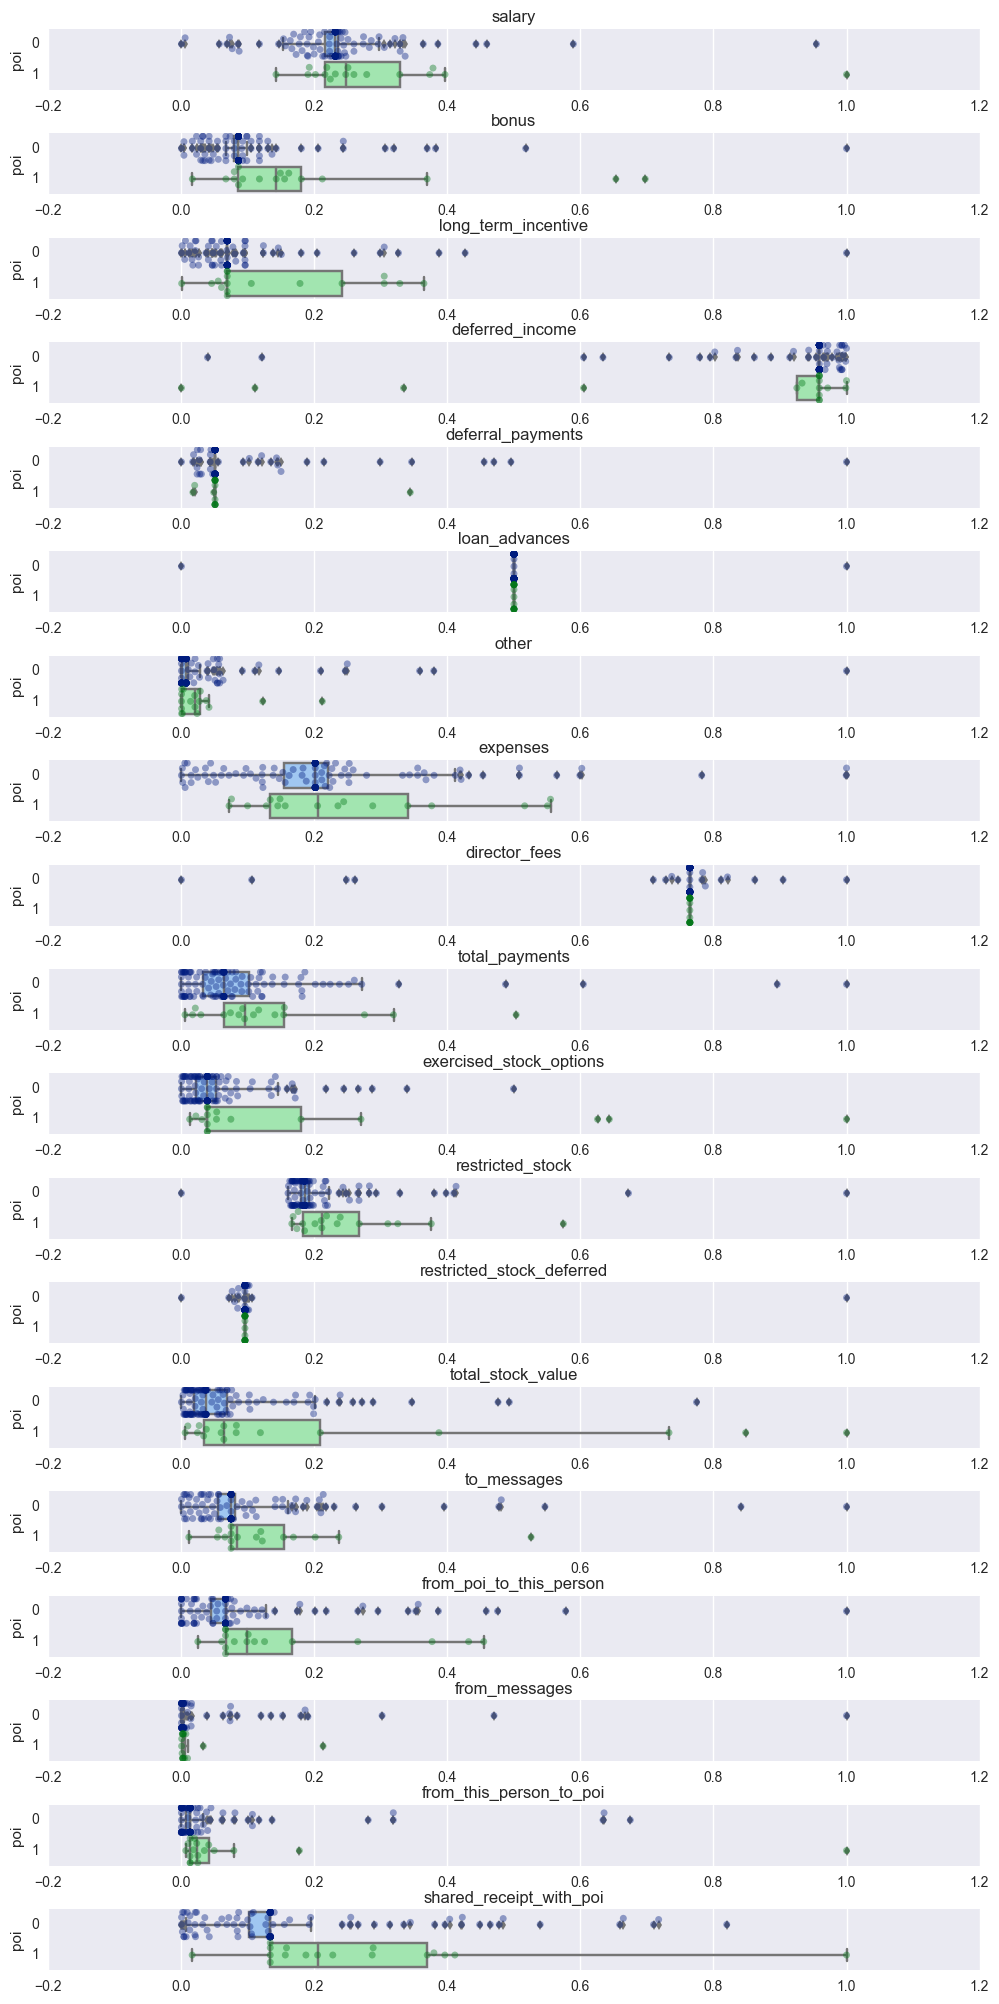

In [641]:
f, xarr = plt.subplots(len(feature_names), figsize=(10, 20))
f.tight_layout()
for i, feature in enumerate(feature_names):
    ax = xarr[i]
    sns.boxplot(data=preproc_data, x=feature, y=label, ax=ax, orient='h', whis=3, palette='pastel')
    sns.swarmplot(data=preproc_data, x=feature, y=label, ax=ax, orient='h', palette='dark', alpha=0.4)
    ax.set_xlabel("")
    ax.set_title(feature)



In [642]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

resampler = ADASYN()
y = preproc_data[label]
X_res, y_res = resampler.fit_sample(preproc_data[feature_names], y)

n_poi = np.sum(y_res)
n_total = y_res.shape[0]
print("Number of POIs: %d" % n_poi)
print("Total number: %d" % n_total)
print("Dataset balance: %0.3f" % y_res.mean())

Number of POIs: 124
Total number: 251
Dataset balance: 0.494


In [708]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)

In [717]:
clf = RandomForestClassifier()
cv = StratifiedKFold(n_splits = 20)
cv_scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=cv)

print("Average F1 cross-val score: %0.3f ± %0.3f" % (cv_scores.mean(), cv_scores.std() * 3))

Average F1 cross-val score: 0.927 ± 0.230


In [718]:
clf.fit(X_train, y_train)
print("Classifier F1 score: %0.3f" % f1_score(y_test, clf.predict(X_test)))
confusion_matrix(y_test, clf.predict(X_test))

Classifier F1 score: 0.981


array([[24,  0],
       [ 1, 26]])

In [712]:
sorted(zip(clf.feature_importances_, feature_names), reverse=True)

[(0.1441043896786125, 'other'),
 (0.10074382344679052, 'from_this_person_to_poi'),
 (0.094595045355815338, 'restricted_stock'),
 (0.071113746124978588, 'from_messages'),
 (0.067692364750035677, 'long_term_incentive'),
 (0.067622331438761202, 'exercised_stock_options'),
 (0.061345987092211493, 'total_payments'),
 (0.061182017487496007, 'bonus'),
 (0.059812171969368166, 'shared_receipt_with_poi'),
 (0.056265714243004895, 'from_poi_to_this_person'),
 (0.055894363001692579, 'deferred_income'),
 (0.054836311667050844, 'total_stock_value'),
 (0.039416112058630708, 'expenses'),
 (0.030265564382394305, 'salary'),
 (0.018020147927344587, 'to_messages'),
 (0.0097670336994401356, 'deferral_payments'),
 (0.0073228756763724177, 'restricted_stock_deferred'),
 (0.0, 'loan_advances'),
 (0.0, 'director_fees')]

# Principal Component visualization

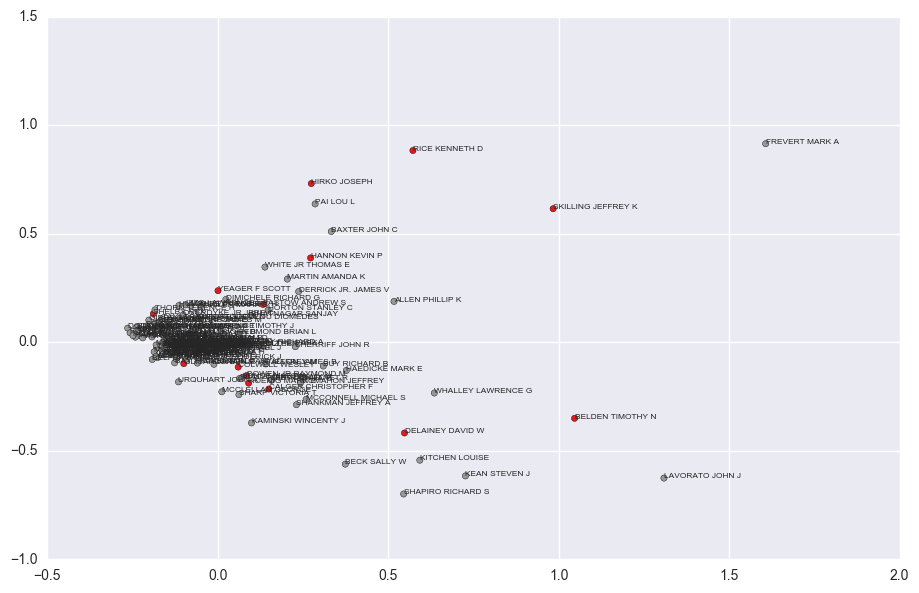

In [713]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(preproc_data[feature_names])

colors = preproc_data[label].as_matrix().astype(int)
sns.plt.scatter(data_pca[:, 0], data_pca[:, 1], c=colors, cmap=plt.cm.Set1_r)

for name, pt in zip(data.full_name, data_pca):
    plt.annotate(name, xy=pt, fontsize=6)



In [651]:
out_1 = np.argmax(data_pca[:, 0])
data.loc[out_1]

full_name                            FREVERT MARK A
salary                                  1.06093e+06
to_messages                                    3275
deferral_payments                       6.42699e+06
total_payments                          1.72525e+07
exercised_stock_options                 1.04335e+07
bonus                                         2e+06
restricted_stock                        4.18867e+06
shared_receipt_with_poi                        2979
restricted_stock_deferred                       NaN
total_stock_value                       1.46222e+07
expenses                                      86987
loan_advances                                 2e+06
from_messages                                    21
other                                   7.42762e+06
from_this_person_to_poi                           6
poi                                           False
director_fees                                   NaN
deferred_income                        -3.36701e+06
long_term_in

In [656]:
sorted(zip(np.abs(pca.components_[0]), feature_names), reverse=True)

[(0.45211998396321135, 'shared_receipt_with_poi'),
 (0.33125424473855092, 'total_payments'),
 (0.31533298102743945, 'bonus'),
 (0.30897935328767101, 'to_messages'),
 (0.30256781096510715, 'from_poi_to_this_person'),
 (0.29867876297905083, 'deferred_income'),
 (0.25121624861728603, 'total_stock_value'),
 (0.22916740449570158, 'from_this_person_to_poi'),
 (0.22769794682395131, 'salary'),
 (0.17720690428861549, 'exercised_stock_options'),
 (0.17384428244488373, 'deferral_payments'),
 (0.15398889680256825, 'long_term_incentive'),
 (0.14695411382294174, 'other'),
 (0.1194162266394521, 'restricted_stock'),
 (0.10714180140663733, 'from_messages'),
 (0.069729262420628935, 'loan_advances'),
 (0.062312674662177915, 'expenses'),
 (0.0357681529191178, 'director_fees'),
 (0.0053721357397115846, 'restricted_stock_deferred')]

# Outlier detection using clustering

In [714]:
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import DistanceMetric

mix = GaussianMixture(n_components=1)
mix.fit(preproc_data)

center = mix.means_[0]
cov = mix.covariances_[0]

metric = DistanceMetric.get_metric('mahalanobis', V=cov)

names_by_distance = data[['full_name', label]].copy()
names_by_distance['distance'] = metric.pairwise([center], preproc_data)[0]
names_by_distance.sort_values(by='distance', ascending=False)

,full_name,poi,distance
11,BHATNAGAR SANJAY,False,11.899056
72,KAMINSKI WINCENTY J,False,11.340321
47,FREVERT MARK A,False,11.337794
105,PICKERING MARK R,False,11.335526
31,DELAINEY DAVID W,True,9.789663
86,MARTIN AMANDA K,False,9.777729
117,SHAPIRO RICHARD S,False,9.652409
122,SKILLING JEFFREY K,True,9.600397
139,WHITE JR THOMAS E,False,9.565224
78,LAVORATO JOHN J,False,9.470530


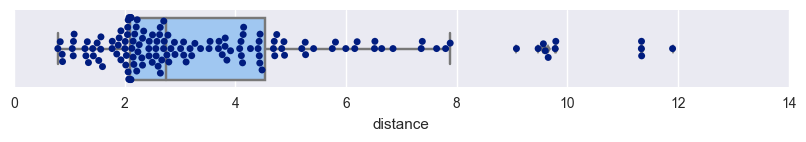

In [657]:
plt.figure(figsize=(10, 1))
sns.swarmplot(x=names_by_distance['distance'], palette='dark')
sns.boxplot(names_by_distance['distance'], palette='pastel');

# Tuning Random Forest Parameters

In [720]:
clf = RandomForestClassifier()
cv = StratifiedKFold(n_splits=20)

In [721]:
from sklearn.model_selection import GridSearchCV

In [722]:
param_grid = {
    'max_depth': range(1, 10),
    'n_estimators': range(1, 10),
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
} 
grid = GridSearchCV(clf, param_grid, scoring='f1', cv=cv)

In [724]:
grid.best_score_

0.92494516594516596

In [729]:
print("Classifier F1 score: %0.3f" % f1_score(y_test, grid.predict(X_test)))
confusion_matrix(y_test, grid.predict(X_test))

Classifier F1 score: 0.962


array([[24,  0],
       [ 2, 25]])

# Splitting train/test before manipulations

### Training 

In [794]:
train_data, test_data = train_test_split(load_data(), test_size=0.2)

imputer = Imputer(strategy='median')
imputer.fit(train_data[feature_names])
imputed_features = imputer.transform(train_data[feature_names])

resampler = ADASYN()
X_train, y_train = resampler.fit_sample(imputed_features, train_data[label])

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

print("F1 score on the training set: %0.3f" % f1_score(y_train, clf.predict(X_train)))

F1 score on the training set: 1.000


### Testing 

In [795]:
X_imputed_test = imputer.transform(test_data[feature_names])
X_test, y_test = resampler.fit_sample(X_imputed_test, test_data[label])

print("F1 score on the testing set: %0.3f" % f1_score(y_test, clf.predict(X_test)))

print(confusion_matrix(y_test, clf.predict(X_test)))

F1 score on the testing set: 0.605
[[21  4]
 [13 13]]


In [796]:
sorted(zip(clf.feature_importances_, feature_names), reverse=True)

[(0.26087322646135785, 'restricted_stock'),
 (0.14602477671150088, 'shared_receipt_with_poi'),
 (0.10394268536569574, 'exercised_stock_options'),
 (0.077719257866316685, 'other'),
 (0.069761545643898581, 'total_stock_value'),
 (0.054481151094496028, 'long_term_incentive'),
 (0.04996534996534998, 'to_messages'),
 (0.047152253924686825, 'deferral_payments'),
 (0.041852695367759936, 'total_payments'),
 (0.03546134172732638, 'from_poi_to_this_person'),
 (0.032365510306686787, 'deferred_income'),
 (0.031478950362075875, 'salary'),
 (0.029787527050954176, 'from_this_person_to_poi'),
 (0.01913372815189426, 'from_messages'),
 (0.0, 'restricted_stock_deferred'),
 (0.0, 'loan_advances'),
 (0.0, 'expenses'),
 (0.0, 'director_fees'),
 (0.0, 'bonus')]

# Explore dataset with decision tree

In [10]:
import pydotplus

from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import f1_score

In [29]:
train_data = load_data()

imputer = Imputer(strategy='median')
imputer.fit(train_data[feature_names])
imputed_features = imputer.transform(train_data[feature_names])

# resampler = RandomOverSampler()
# X_train, y_train = resampler.fit_sample(imputed_features, train_data[label])
X_train, y_train = imputed_features, train_data[label]

clf = DecisionTreeClassifier(random_state=42, criterion='gini')
clf.fit(X_train, y_train)

print("F1 score on the training set: %0.3f" % f1_score(y_train, clf.predict(X_train)))

F1 score on the training set: 1.000


In [30]:
sorted(zip(clf.feature_importances_, feature_names), reverse=True)

[(0.17991970825570602, 'expenses'),
 (0.17293720637861443, 'total_payments'),
 (0.17069132961795336, 'bonus'),
 (0.1266207941967791, 'restricted_stock'),
 (0.10719248329252962, 'long_term_incentive'),
 (0.064889749743848701, 'other'),
 (0.061645594347515868, 'total_stock_value'),
 (0.058360352014821683, 'from_messages'),
 (0.050023158869847151, 'exercised_stock_options'),
 (0.0077196232823839358, 'from_this_person_to_poi'),
 (0.0, 'to_messages'),
 (0.0, 'shared_receipt_with_poi'),
 (0.0, 'salary'),
 (0.0, 'restricted_stock_deferred'),
 (0.0, 'loan_advances'),
 (0.0, 'from_poi_to_this_person'),
 (0.0, 'director_fees'),
 (0.0, 'deferred_income'),
 (0.0, 'deferral_payments')]

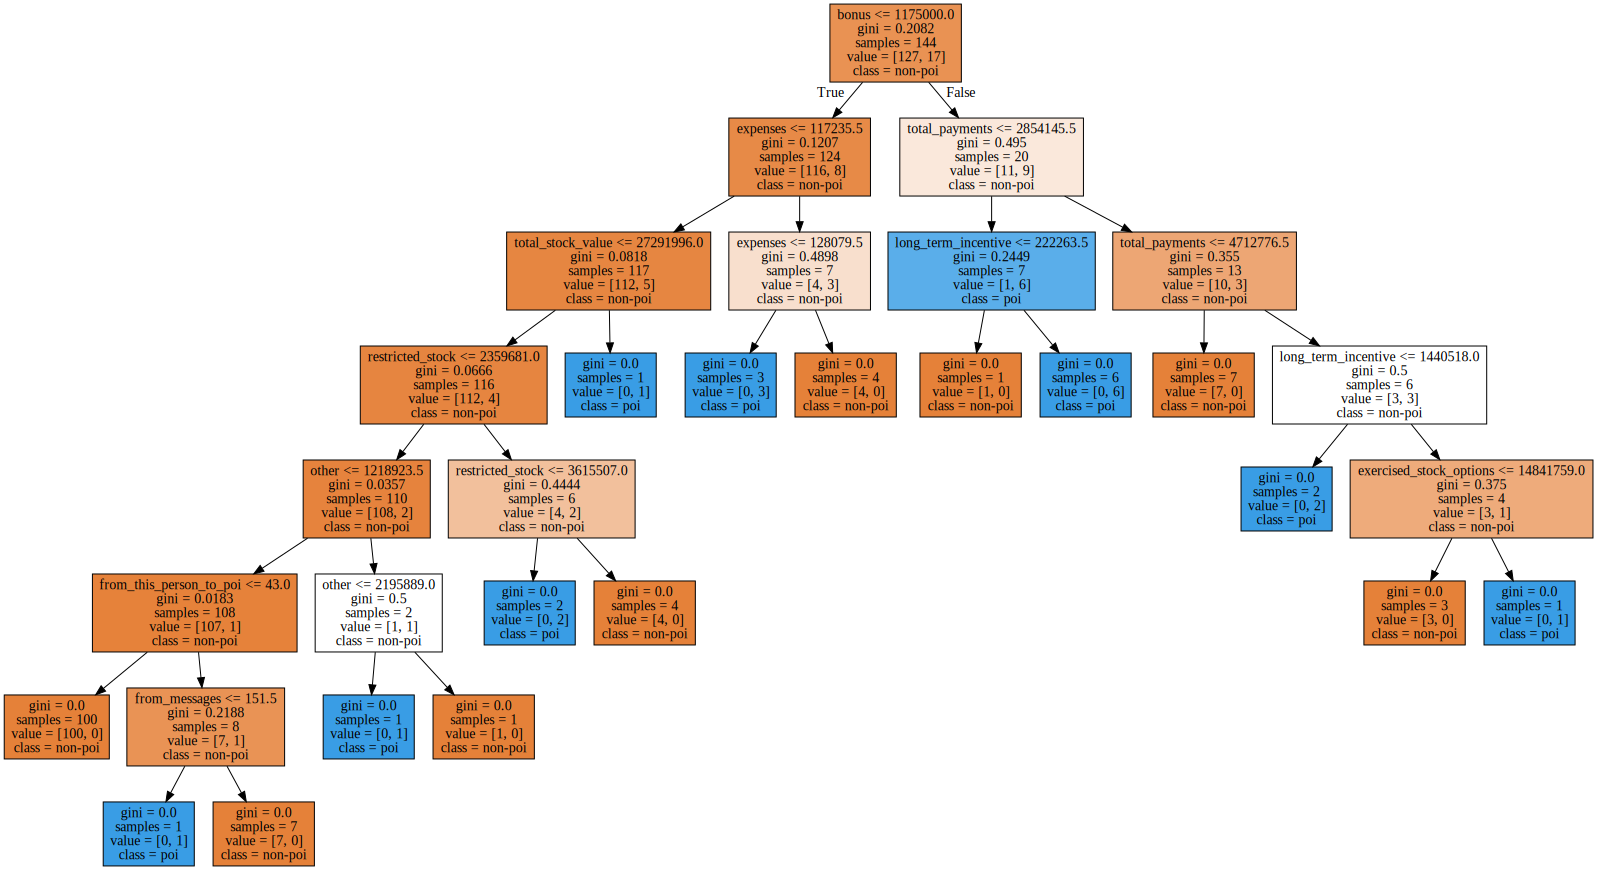

In [31]:
dot_data = export_graphviz(clf, out_file=None, 
                                feature_names=feature_names, 
                                filled=True, 
                                class_names=['non-poi', 'poi'])
graph = pydotplus.graph_from_dot_data(dot_data)

from IPython.display import SVG
SVG(graph.create_svg())

### Follow-up questions
* What's a 'gini' index? 
* What's the difference between 'gini' and 'entropy'
* How feature_importances are related to the tree visualization? 
